In [1]:
!pip install pypdf2
# import streamlit as st
import requests
import sqlite3
import json
import PyPDF2  # For PDF processing
from langchain.schema import Document
# from docGPT import DocGPT
import base64
import matplotlib.pyplot as plt

# API Configuration
# STOCK_API_KEY = "43YRXE6IDCMHN6W7"  # Replace with your real API Key
STOCK_API_KEY = "43YRXE6IDCMHN6W7"
STOCK_BASE_URL = "https://www.alphavantage.co/query"

NEWS_API_KEY = "43YRXE6IDCMHN6W7"  # Replace with your real News API Key
NEWS_API_URL = "https://www.alphavantage.co/query"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.0 MB/s eta 0:00:00


In [2]:
def fetch_stock_data():
    """Fetches real-time stock data from Alpha Vantage API."""
    params = {
        "function": "TIME_SERIES_MONTHLY",
        "symbol": "IBM",
        "apikey": STOCK_API_KEY
    }
    response = requests.get(STOCK_BASE_URL, params=params)

    if response.status_code == 200:
        stock_data = response.json()
        time_series = stock_data.get("Monthly Time Series", {})

        if not time_series:
            st.warning("No stock data found.")
            return []

        return [
            Document(page_content=f"Stock Date: {date}\nStock Data: {json.dumps(data)}")
            for date, data in time_series.items()
        ]
    else:
        # st.error(f"Stock API request failed: {response.status_code}")
        return []

# Fetch Stock-Related News from API
def fetch_stock_news():
    """Fetches real-time stock-related news from Alpha Vantage API."""
    params = {
        "function": "NEWS_SENTIMENT",
        "tickers": "AAPL",
        "apikey": NEWS_API_KEY
    }
    response = requests.get(NEWS_API_URL, params=params)

    if response.status_code == 200:
        news_data = response.json()
        articles = news_data.get("feed", [])

        if not articles:
            st.warning("No relevant news found.")
            return []

        return [
            Document(page_content=f"News Title: {article['title']}\nSummary: {article['summary']}\nSentiment: {article['overall_sentiment_label']}")
            for article in articles
        ]
    else:
        # st.error(f"News API request failed: {response.status_code}")
        return []

# Load Pre-generated QA Pairs
def load_qa_pairs():
    """Loads pre-generated QA pairs from the JSON file."""
    try:
        with open("news_qa_pairs.json", "r") as f:
            qa_data = json.load(f)

        return [Document(page_content=f"Q: {item['question']} A: {item['answer']}") for item in qa_data]
    except Exception as e:
        # st.error(f"Error loading QA pairs: {e}")
        return []

def extract_text_from_file(uploaded_file):
    """Extracts text from uploaded .txt or .pdf files."""
    if uploaded_file is not None:
        file_extension = uploaded_file.name.split(".")[-1].lower()

        if file_extension == "txt":
            return uploaded_file.read().decode("utf-8")
        elif file_extension == "pdf":
            pdf_reader = PyPDF2.PdfReader(uploaded_file)
            return "\n".join([page.extract_text() for page in pdf_reader.pages if page.extract_text()])
        else:
            return None
    return None

In [3]:
!pip install -q yfinance

import pandas as pd
import numpy as np
import yfinance as yf
import datetime

df = yf.download("AAPL")

dataset_x = []
dataset_y = []

# Loop through the DataFrame to create Q&A pairs
for date, row in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')  # Format date
    question = f"What was the stock data on {date_str}?"

    # Extract stock details by correctly referencing MultiIndex columns
    stock_data = f"Stock Data for AAPL on {date_str}: " \
                 f"Open {row[('Open', 'AAPL')]}, Close {row[('Close', 'AAPL')]}, " \
                 f"High {row[('High', 'AAPL')]}, Low {row[('Low', 'AAPL')]}, " \
                 f"Volume {row[('Volume', 'AAPL')]}"

    dataset_x.append(question)
    dataset_y.append(stock_data)

# Print results
print("dataset_x:", len(dataset_x))
print("dataset_y:", len(dataset_y))


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


dataset_x: 11150
dataset_y: 11150


In [4]:
df = pd.read_csv("analyst_ratings_processed.csv")

In [5]:
for _, row in df.iterrows():
    date_str = row['Date']  # Treat date as string
    question = f"What was the stock news on {date_str}?"
    stock_news = f"Stock news for {date_str}: {row['Stock News']}"

    dataset_x.append(question)
    dataset_y.append(stock_news)

In [6]:
print("dataset_x:", len(dataset_x))
print("dataset_y:", len(dataset_y))

dataset_x: 1059725
dataset_y: 1059725


In [7]:
dataset_x = dataset_x[0:50000]
dataset_y = dataset_y[0:50000]

In [8]:
print("dataset_x:", len(dataset_x))
print("dataset_y:", len(dataset_y))

dataset_x: 50000
dataset_y: 50000


In [9]:
stock_docs = fetch_stock_data()
news_docs = fetch_stock_news()
qa_docs = load_qa_pairs()

docs = stock_docs + news_docs + qa_docs

In [10]:
len(docs)

479

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

dataset_x: 50479
dataset_y: 50479


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1/5, Train Loss: 1.1166, Train Acc: 0.8767, Val Loss: 0.3755, Val Acc: 0.9311
Epoch 2/5, Train Loss: 0.3870, Train Acc: 0.9301, Val Loss: 0.3392, Val Acc: 0.9361
Epoch 3/5, Train Loss: 0.3543, Train Acc: 0.9342, Val Loss: 0.3228, Val Acc: 0.9382
Epoch 4/5, Train Loss: 0.3358, Train Acc: 0.9364, Val Loss: 0.3105, Val Acc: 0.9398
Epoch 5/5, Train Loss: 0.3225, Train Acc: 0.9381, Val Loss: 0.3011, Val Acc: 0.9410


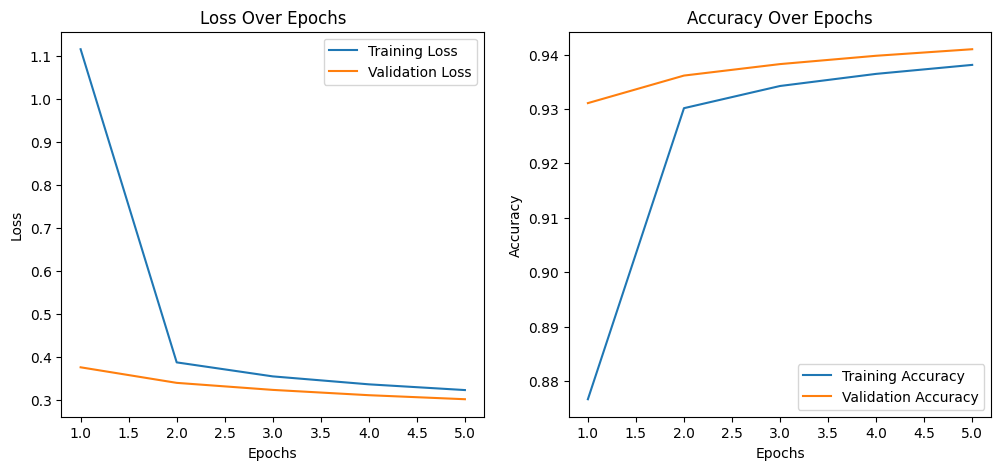

✅ Model saved successfully in 'saved_model' directory.


In [11]:
import json
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
from torch.utils.data import DataLoader, Dataset, random_split
import torch.optim as optim
from langchain.docstore.document import Document

# Custom Dataset Class
class TextDataset(Dataset):
    def __init__(self, tokenizer, dataset_x, dataset_y, max_length=256):
        self.tokenizer = tokenizer
        self.dataset_x = dataset_x
        self.dataset_y = dataset_y
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset_x)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.dataset_x[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        target_encoding = self.tokenizer(
            self.dataset_y[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": target_encoding["input_ids"].squeeze(0),
        }

# DocGPT Training Class
class DocGPT:
    def __init__(self, docs, model_path="google/flan-t5-base", embedding_model="BAAI/bge-large-en", epochs=5, batch_size=32):
        self.docs = docs
        self.model_path = model_path
        self.embedding_model = embedding_model
        self.epochs = epochs
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path, torch_dtype=torch.float32 if self.device == "cuda" else torch.float32)
        self.model.to(self.device)
        self.train_model()
        self.save_model()

    def train_model(self):
        # dataset_x, dataset_y = [], []
        for doc in self.docs:
            content = doc.page_content.strip()
            if content.startswith("Q:") and " A: " in content:
                question, answer = content.split(" A: ", 1)
                dataset_x.append(question)
                dataset_y.append(answer)
            elif "Stock Date" in content and "Stock Data" in content:
                date = content.split(" ")[2]
                dataset_x.append(f"What was the stock data on {date}?")
                dataset_y.append(content)
            elif "News Title:" in content:
                dataset_x.append("Summarize this news article.")
                dataset_y.append(content)
            else:
                dataset_x.append(content)
                dataset_y.append(content)
        if not dataset_x:
            raise ValueError("No valid data found for training!")
        print("dataset_x:", len(dataset_x))
        print("dataset_y:", len(dataset_y))
        dataset = TextDataset(self.tokenizer, dataset_x, dataset_y)
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.AdamW(self.model.parameters(), lr=5e-5)
        training_losses, validation_losses = [], []
        training_accuracies, validation_accuracies = [], []

        for epoch in range(self.epochs):
            # print(f"Epoch {epoch+1}/{self.epochs}")
            self.model.train()
            total_train_loss, correct_train, total_train = 0, 0, 0
            for batch in train_loader:
                input_ids, attention_mask, labels = batch["input_ids"].to(self.device), batch["attention_mask"].to(self.device), batch["labels"].to(self.device)
                optimizer.zero_grad()
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                correct_train += (outputs.logits.argmax(dim=-1) == labels).sum().item()
                total_train += labels.numel()
            training_losses.append(total_train_loss / len(train_loader))
            training_accuracies.append(correct_train / total_train)

            self.model.eval()
            total_val_loss, correct_val, total_val = 0, 0, 0
            with torch.no_grad():
                for batch in val_loader:
                    input_ids, attention_mask, labels = batch["input_ids"].to(self.device), batch["attention_mask"].to(self.device), batch["labels"].to(self.device)
                    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    total_val_loss += outputs.loss.item()
                    correct_val += (outputs.logits.argmax(dim=-1) == labels).sum().item()
                    total_val += labels.numel()
            validation_losses.append(total_val_loss / len(val_loader))
            validation_accuracies.append(correct_val / total_val)

            print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {training_losses[-1]:.4f}, Train Acc: {training_accuracies[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Val Acc: {validation_accuracies[-1]:.4f}")

        self.plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

    def plot_metrics(self, training_losses, validation_losses, training_accuracies, validation_accuracies):
        epochs = range(1, len(training_losses) + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, training_losses, label='Training Loss')
        plt.plot(epochs, validation_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss Over Epochs')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, training_accuracies, label='Training Accuracy')
        plt.plot(epochs, validation_accuracies, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.legend()

        plt.show()

    def save_model(self):
        self.model.save_pretrained("saved_model")
        self.tokenizer.save_pretrained("saved_model")
        print("✅ Model saved successfully in 'saved_model' directory.")

# Train Model
docgpt = DocGPT(docs)
